In [1]:
import sys
import os
import struct
import time as time
import numpy as np
import pandas as pd
import h5py
import PIL.Image
from scipy import stats
from itertools import chain
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import csv
from itertools import zip_longest

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models

In [2]:
import neurogen.numpy_utility as pnu
from neurogen.plots import display_candidate_loss
from neurogen.file_utility import save_stuff, flatten_dict, embed_dict
from neurogen.torch_fwrf import get_value

from neurogen.torch_fwrf import learn_params_ridge_regression, get_predictions, Torch_fwRF_voxel_block
from neurogen.encoding import load_encoding
from neurogen.visualize import center_crop

In [3]:
#paths

nsd_root = "data/nsd/"
# stim_root = "/home/hhan228/memorability/Mansoure/" + "nsd_stimuli/"
# beta_root = nsd_root + "nsd_beta/"
#mask_root = nsd_root + "mask/ppdata/"
#roi_root = nsd_root + "freesurfer/"
meanROIbeta_root = nsd_root + "roiavgbeta_neurogen/"
# weight_root = "neurogen/output/"
weight_base_dir = "/home/hhan228/memorability/Willow/neurogen_output/"
# weight_root = weight_base_dir+"alexnet/"
weight_root = weight_base_dir+"resnet/"

exp_design_file = nsd_root + "nsd_expdesign.mat"
stim_file = nsd_root + "shared1000_original.npy"

In [4]:
# device = torch.device("cuda:1")
device = torch.device("cpu")

## With memorability-controlled images

In [5]:
ctrld_dir = "data/memorability_controlled_test_70p_new/"
high_imgs = sorted([f for f in os.listdir(ctrld_dir+"increased/") if os.path.isfile(os.path.join(ctrld_dir+"increased/", f))])
low_imgs = sorted([f for f in os.listdir(ctrld_dir+"decreased/") if os.path.isfile(os.path.join(ctrld_dir+"decreased/", f))])
regen_imgs = sorted([f for f in os.listdir(ctrld_dir+"regen/") if os.path.isfile(os.path.join(ctrld_dir+"regen/", f))])

In [6]:
default_ROIs = [
    'OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces',
    'EBA', 'FBA1', 'FBA2', 'mTLbodies',
    'OPA', 'PPA', 'RSC',
    # 'OWFA', 'VWFA1', 'VWFA2', 'mfswords', 'mTLwords', 
    'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4',
    'L-hippocampus', 'L-amygdala', 'R-hippocampus', 'R-amygdala'
]

t_test_dict = {
    "subject": [],
    "ttest_p": [],
    "wilcoxon_p": [],
    "pearson_p": [],
    "pearson_coef": []
}

for roi in default_ROIs:
    t_test_dict[f"{roi}_high_low_p"] = []
    t_test_dict[f"{roi}_orig_high_p"] = []
    t_test_dict[f"{roi}_orig_low_p"] = []
    t_test_dict[f"{roi}_recon_high_p"] = []
    t_test_dict[f"{roi}_recon_low_p"] = []

In [7]:
# 50%
# ctrld_nids = [14, 19, 40, 53, 55, 58, 62, 77, 84, 86, 88, 89, 90, 101, 113, 147, 157, 166, 168, 170, 175, 179, 181, 183, 185, 200, 201, 203, 205, 213, 215, 225, 236, 242, 255, 261, 264, 275, 283, 292, 317, 328, 329, 333, 347, 353, 355, 361, 366, 374, 383, 386, 389, 390, 395, 396, 400, 402, 403, 407, 416, 419, 429, 430, 446, 448, 452, 456, 460, 471, 501, 506, 513, 514, 526, 528, 530, 537, 540, 543, 556, 557, 561, 562, 566, 572, 574, 575, 582, 583, 592, 593, 603, 607, 617, 620, 626, 628, 631, 632, 637, 639, 643, 644, 649, 651, 657, 681, 682, 685, 686, 689, 705, 710, 728, 731, 738, 739, 745, 749, 752, 754, 757, 758, 767, 782, 793, 807, 825, 828, 829, 834, 850, 852, 868, 873, 883, 886, 920, 934, 935, 940, 944, 945, 955, 959, 964, 975, 982, 996]

# 70%
# ctrld_nids = [14, 19, 24, 40, 53, 55, 57, 79, 84, 86, 88, 89, 90, 113, 117, 147, 154, 157, 162, 166, 168, 170, 173, 175, 179, 181, 183, 185, 188, 200, 201, 203, 205, 215, 217, 230, 231, 236, 242, 246, 250, 255, 256, 275, 281, 283, 296, 310, 315, 317, 329, 330, 333, 347, 349, 351, 355, 366, 374, 383, 386, 389, 390, 395, 396, 400, 402, 403, 407, 419, 430, 446, 448, 452, 456, 460, 471, 492, 501, 502, 506, 513, 514, 526, 528, 530, 532, 540, 547, 556, 557, 562, 566, 571, 574, 582, 592, 593, 607, 620, 622, 625, 626, 628, 631, 632, 637, 639, 643, 644, 646, 649, 651, 657, 680, 681, 682, 686, 689, 692, 705, 723, 728, 731, 733, 738, 745, 749, 752, 754, 757, 758, 766, 767, 778, 782, 785, 793, 807, 825, 828, 829, 834, 850, 852, 858, 860, 867, 868, 873, 883, 893, 898, 914, 927, 934, 940, 944, 945, 955, 959, 964, 975, 979, 982, 994, 996, 999]

# 70% && S4, S8
# ctrld_nids = [14, 19, 24, 40, 53, 57, 79, 84, 86, 88, 89, 90, 113, 117, 147, 154, 157, 162, 166, 168, 170, 173, 175, 179, 181, 183, 185, 188, 200, 201, 205, 215, 217, 230, 231, 242, 246, 250, 255, 256, 275, 281, 283, 296, 310, 315, 317, 329, 330, 333, 347, 349, 351, 355, 366, 374, 383, 386, 390, 396, 400, 402, 403, 407, 419, 430, 446, 448, 452, 456, 460, 471, 492, 502, 506, 513, 526, 528, 530, 532, 540, 556, 557, 562, 566, 571, 592, 593, 620, 622, 625, 626, 628, 631, 632, 639, 643, 644, 646, 649, 651, 657, 680, 682, 686, 689, 692, 705, 723, 728, 731, 738, 745, 749, 754, 757, 758, 766, 767, 778, 782, 785, 807, 825, 828, 829, 834, 850, 852, 858, 860, 867, 868, 873, 883, 893, 898, 914, 927, 934, 940, 944, 945, 955, 959, 964, 975, 979, 982, 994, 996, 999]

# 129
# ctrld_nids = [14, 24, 40, 53, 57, 79, 84, 86, 88, 89, 90, 113, 117, 147, 154, 157, 162, 166, 168, 170, 173, 175, 179, 181, 183, 185, 188, 200, 201, 205, 215, 230, 231, 242, 246, 250, 255, 256, 283, 296, 310, 315, 317, 329, 330, 333, 347, 355, 366, 374, 383, 386, 390, 396, 400, 402, 403, 419, 430, 448, 452, 456, 460, 471, 492, 502, 506, 526, 528, 530, 532, 540, 556, 557, 562, 566, 592, 593, 626, 628, 632, 639, 644, 646, 649, 651, 657, 680, 682, 686, 689, 692, 705, 728, 731, 738, 745, 749, 754, 757, 766, 767, 778, 782, 785, 807, 825, 828, 829, 834, 850, 852, 858, 867, 873, 883, 893, 898, 914, 934, 944, 945, 955, 959, 964, 975, 982, 994, 996]

# 144
ctrld_nids = [14, 24, 40, 53, 55, 57, 79, 84, 86, 88, 89, 90, 113, 117, 147, 154, 157, 162, 166, 168, 170, 173, 175, 179, 181, 183, 185, 188, 200, 201, 203, 205, 215, 230, 231, 236, 242, 246, 250, 255, 256, 283, 296, 310, 315, 317, 329, 330, 333, 347, 355, 366, 374, 383, 386, 390, 395, 396, 400, 402, 403, 419, 430, 448, 452, 456, 460, 471, 492, 501, 502, 506, 514, 526, 528, 530, 532, 540, 547, 556, 557, 562, 566, 574, 582, 592, 593, 607, 626, 628, 632, 637, 639, 644, 646, 649, 651, 657, 680, 681, 682, 686, 689, 692, 705, 728, 731, 733, 738, 745, 749, 752, 754, 757, 766, 767, 778, 782, 785, 793, 807, 825, 828, 829, 834, 850, 852, 858, 867, 873, 883, 893, 898, 914, 934, 944, 945, 955, 959, 964, 975, 982, 994, 996]

# 80%
# ctrld_nids = [7, 14, 19, 24, 40, 49, 53, 55, 57, 79, 84, 86, 88, 89, 90, 106, 113, 117, 125, 147, 154, 157, 162, 166, 168, 170, 173, 175, 179, 181, 183, 185, 188, 200, 201, 202, 203, 205, 215, 217, 230, 231, 236, 242, 246, 249, 250, 255, 256, 275, 281, 283, 296, 310, 315, 317, 329, 330, 333, 345, 347, 349, 351, 355, 366, 374, 383, 386, 389, 390, 395, 396, 400, 402, 403, 407, 419, 430, 435, 446, 448, 450, 452, 456, 458, 460, 471, 492, 493, 501, 502, 506, 513, 514, 526, 528, 530, 532, 540, 547, 556, 557, 562, 566, 571, 574, 582, 592, 593, 602, 604, 607, 618, 620, 622, 625, 626, 628, 629, 631, 632, 637, 639, 643, 644, 646, 649, 651, 657, 680, 681, 682, 686, 689, 692, 705, 723, 728, 731, 733, 738, 745, 749, 752, 754, 757, 758, 766, 767, 778, 782, 785, 793, 803, 807, 825, 828, 829, 834, 850, 852, 854, 858, 860, 867, 868, 873, 883, 893, 898, 914, 927, 934, 940, 944, 945, 955, 959, 964, 975, 979, 982, 994, 996, 999]

# iqr
# ctrld_nids = [14, 19, 24, 40, 53, 55, 57, 79, 84, 86, 88, 89, 90, 106, 113, 117, 147, 154, 157, 162, 166, 168, 170, 173, 175, 179, 181, 183, 185, 188, 200, 201, 203, 205, 215, 217, 230, 231, 236, 242, 246, 249, 250, 255, 256, 275, 281, 283, 296, 310, 315, 317, 329, 330, 333, 345, 347, 349, 351, 355, 366, 374, 383, 386, 389, 390, 395, 396, 400, 402, 403, 407, 419, 430, 446, 448, 450, 452, 456, 458, 460, 471, 492, 501, 502, 506, 513, 514, 526, 528, 530, 532, 540, 547, 556, 557, 562, 566, 571, 574, 582, 592, 593, 607, 618, 620, 622, 625, 626, 628, 631, 632, 637, 639, 643, 644, 646, 649, 651, 657, 680, 681, 682, 686, 689, 692, 705, 723, 728, 731, 733, 738, 745, 749, 752, 754, 757, 758, 766, 767, 778, 782, 785, 793, 803, 807, 825, 828, 829, 834, 850, 852, 854, 858, 860, 867, 868, 873, 883, 893, 898, 914, 927, 934, 940, 944, 945, 955, 959, 964, 975, 979, 982, 994, 996, 999]
print(len(ctrld_nids))

144


### Load subject

In [183]:
# parameters
subject = 8
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
model_name = 'dnn_fwrf'

# number of trials for all subjects
trials = np.array([30000, 30000, 24000, 22500, 30000, 24000, 30000, 22500])

# subj_dir = ctrld_dir+f"subj{subject:02d}/"
subj_dir = ctrld_dir+f"including_memory/resnet_{len(ctrld_nids)}/subj{subject:02d}/"
os.makedirs(subj_dir, exist_ok=True)

In [184]:
# load behavior data

exp_design = loadmat(exp_design_file)
# order of image id in trials
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)
print('ordering shape', ordering.shape)
# image id for each subject
subject_idx  = exp_design['subjectim']
print('subject_idx shape', subject_idx.shape)
# shared image id
shared_idx = exp_design['sharedix']

ordering shape (30000,)
subject_idx shape (8, 10000)


In [185]:
image_data = np.load("data/nsd/shared1000_227.npy")
image_data = image_data.astype(np.float32) / 255.

print('image data shape', image_data.shape)

image data shape (1000, 3, 227, 227)


In [186]:
# plt.imshow(image_data[0].transpose(1, 2, 0))

In [187]:
# choose the 1000 shared images

data_size = trials[subject-1]
ordering_data = ordering[:data_size]
print(ordering_data.shape)

(22500,)


In [188]:
# Subject 3, 6: [55, 236, 395, 514, 547, 582, 637, 681, 733, 752]
# Subject 4, 8: [55, 203, 236, 395, 501, 514, 547, 574, 582, 607, 637, 681, 733, 752, 793]

In [189]:
# shared_mask = ordering_data<1000  # the first 1000 indices are the shared indices
shared_mask = np.in1d(ordering_data, ctrld_nids)
test_size = np.sum(shared_mask)
print('test size', test_size)

test size 298


In [190]:
# load beta
ROIs = [
    'OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces',
    'EBA', 'FBA1', 'FBA2', 'mTLbodies',
    'OPA', 'PPA', 'RSC',
    'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4',
    'L-hippocampus', 'L-amygdala', 'R-hippocampus', 'R-amygdala'
]

roi_num = len(ROIs)
roi_data = np.zeros([data_size, roi_num])
n = 0
del_idx = []
for roi in ROIs:
    roi_data[:,n] = np.genfromtxt(meanROIbeta_root + f'subj{subject:02d}/meanbeta_' + roi + '.txt')
    if np.isnan(np.sum(roi_data[:,n])):
        print(roi)
        del_idx.append(n)
    n += 1

ROIs_bool = np.ones((23,1), dtype='bool')
ROIs_bool[del_idx] = False

roi_data = np.delete(roi_data, del_idx, axis=1)
test_roi_data = roi_data[shared_mask]

print('test beta shape', test_roi_data.shape)

test beta shape (298, 23)


In [191]:
# load params
model_params_set = h5py.File(weight_root+f'S{subject:02d}/model_params.h5py' , 'r')
# model_params_set = h5py.File(weight_root+f'S{subject:02d}/dnn_fwrf/model_params.h5py' , 'r')
model_params = embed_dict({k: np.copy(d) for k,d in model_params_set.items()})
model_params_set.close()

# load encoding models
fwrf, fmaps = load_encoding(model_params, fmap_name='resnet', device=device)

In [192]:
# predict brain response
voxel_pred = get_predictions(image_data, fmaps, fwrf, model_params['params'])
test_voxel_pred = voxel_pred[ordering[:data_size][shared_mask]]
print('test pred shape', test_voxel_pred.shape)

samples [  900:999  ] of 1000, voxels [     0:22    ] of 23
---------------------------------------
total time = 4.896741s
sample throughput = 0.004897s/sample
voxel throughput = 0.212902s/voxel
test pred shape (298, 23)


(1000, 23)


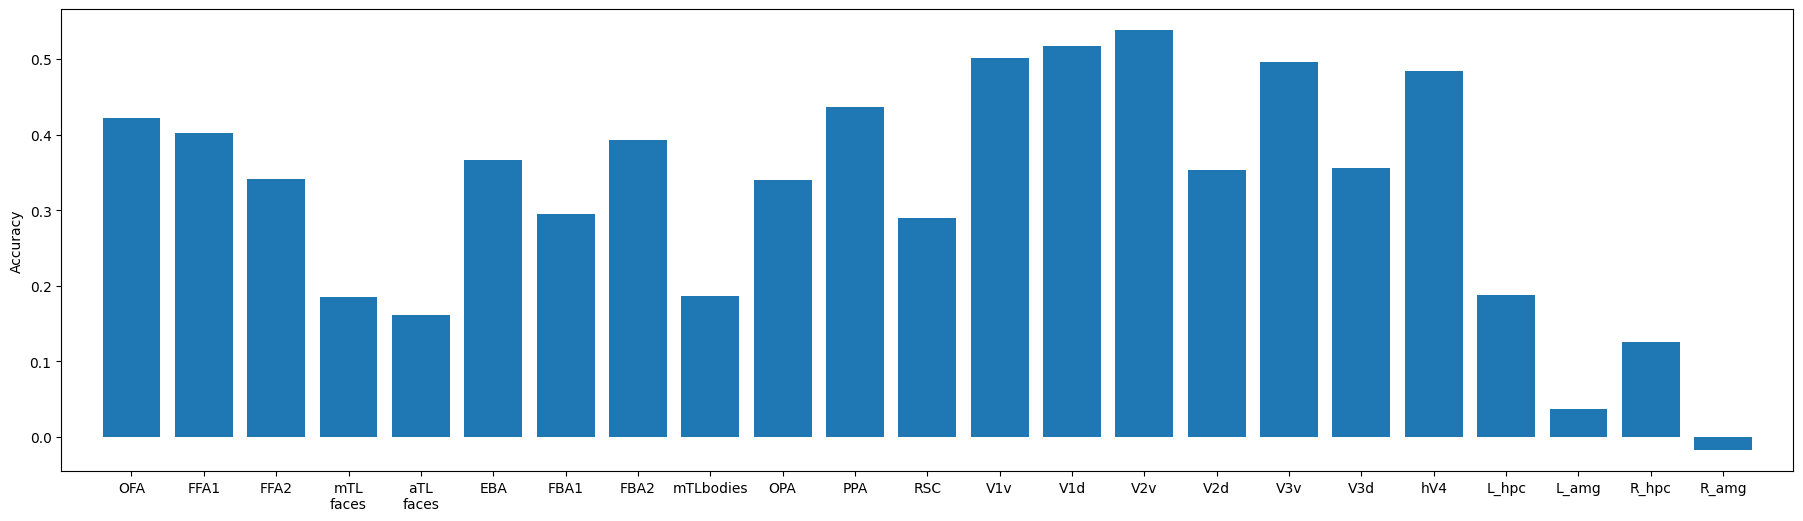

In [193]:
# correlate predicted response and beta
accuracy = np.zeros(shape=(test_voxel_pred.shape[1]))

for v in range(test_voxel_pred.shape[1]):
    accuracy[v] = np.corrcoef(test_roi_data[:,v], test_voxel_pred[:,v])[0,1]  
    

accuracy = np.nan_to_num(accuracy)

# plot the accuracy for all rois
# ROIs_label = ['OFA', 'FFA1', 'FFA2', 'mTL \n faces', 'aTL \n faces', 'EBA', 'FBA1', 'FBA2', 'mTL \n bodies', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA1', 'VWFA2', 'mfs \n words', 'mTL \n words', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
ROIs_label = ['OFA', 'FFA1', 'FFA2', 'mTL\nfaces', 'aTL\nfaces', 'EBA', 'FBA1', 'FBA2', 'mTLbodies', 'OPA', 'PPA', 'RSC', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'L_hpc', 'L_amg', 'R_hpc', 'R_amg']
ROIs_label = np.delete(ROIs_label,del_idx) 

plt.figure(figsize=(16,6))
plt.bar(ROIs_label,accuracy)
plt.ylabel('Accuracy')

plt.gca().margins(x=0.025)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2 # inch margin
s = maxsize/plt.gcf().dpi*test_voxel_pred.shape[1]+2*m
margin = m/plt.gcf().get_size_inches()[0]
plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

plt.savefig(subj_dir+'accuracy.png', bbox_inches='tight')

pred_act = np.zeros((1000,23))
pred_act[:,ROIs_bool[:,0]] = voxel_pred
print(pred_act.shape)

with open(subj_dir + 'voxel_pred_nsd.npy', 'wb') as f:
    np.save(f, pred_act)

save_acc = np.zeros([1,23])
save_acc[:,ROIs_bool[:,0]] = accuracy

with open(subj_dir + 'acc.npy', 'wb') as f:
    np.save(f, save_acc)

In [194]:
# for i, imfile in enumerate(regen_imgs):
#     regen_img = PIL.Image.open(ctrld_dir+"regen/"+imfile).convert("RGB").resize((227, 227))
#     regen_img = np.array(regen_img, dtype=np.float32) / 255.
#     image_data[ctrld_nids[i]] = regen_img.transpose((2, 0, 1))

for i, imfile in enumerate(regen_imgs):
    nid = int(imfile.split("_")[0].split("shared")[-1])-1
    if nid in ctrld_nids:
        regen_img = PIL.Image.open(ctrld_dir+"regen/"+imfile).convert("RGB").resize((227, 227))
        regen_img = np.array(regen_img, dtype=np.float32) / 255.
        image_data[nid] = regen_img.transpose((2, 0, 1))

image_data.shape

(1000, 3, 227, 227)

In [195]:
# plt.imshow(image_data[ctrld_nids[0]].transpose(1, 2, 0))

In [196]:
# predict brain response
voxel_pred = get_predictions(image_data, fmaps, fwrf, model_params['params'])
regen_voxel_pred = voxel_pred[ordering[:data_size][shared_mask]]
# shuffled_voxel_pred = # shuffle 100 times for each participants non-parametric

samples [  900:999  ] of 1000, voxels [     0:22    ] of 23
---------------------------------------
total time = 4.939736s
sample throughput = 0.004940s/sample
voxel throughput = 0.214771s/voxel


regen pred shape (298, 23)
(1000, 23)


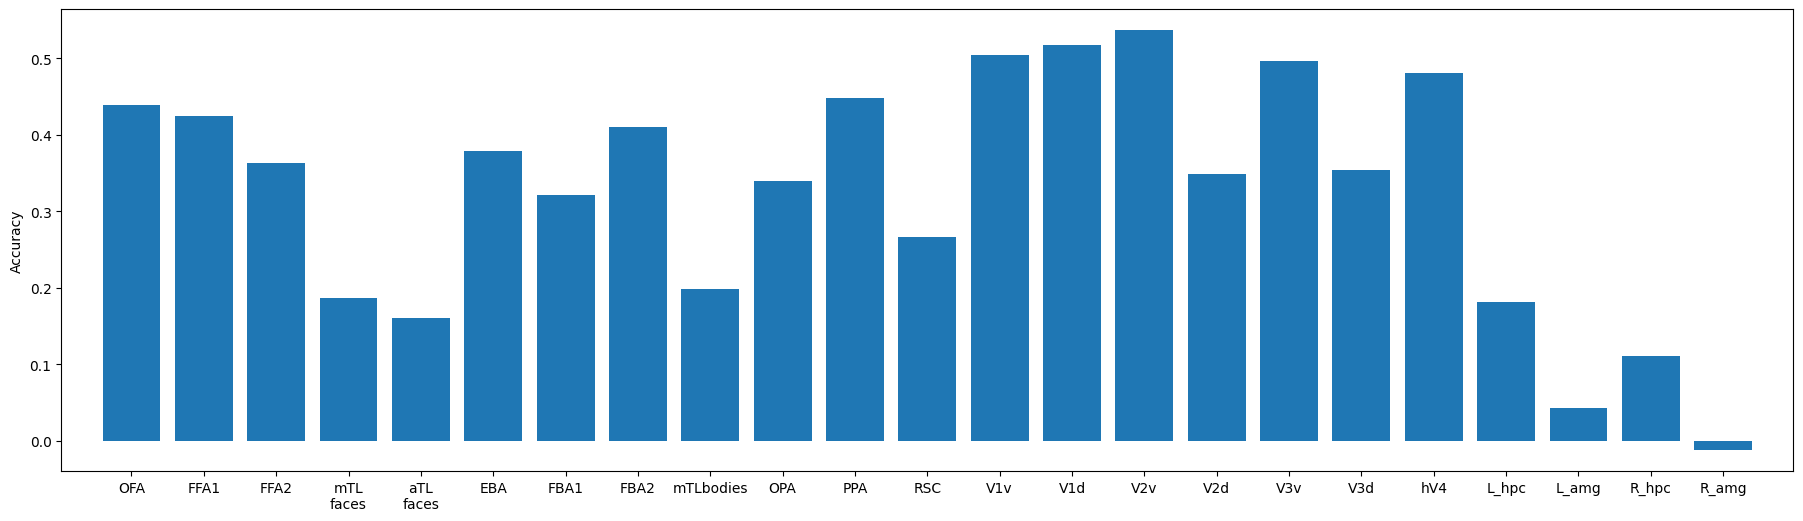

In [197]:
print('regen pred shape', regen_voxel_pred.shape)
accuracy_regen = np.zeros(shape=(regen_voxel_pred.shape[1]))

for v in range(regen_voxel_pred.shape[1]):    
    accuracy_regen[v] = np.corrcoef(test_roi_data[:,v], regen_voxel_pred[:,v])[0,1]  
    

accuracy_regen = np.nan_to_num(accuracy_regen)

# plot the accuracy for all rois
# ROIs_label = ['OFA', 'FFA1', 'FFA2', 'mTL \n faces', 'aTL \n faces', 'EBA', 'FBA1', 'FBA2', 'mTL \n bodies', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA1', 'VWFA2', 'mfs \n words', 'mTL \n words', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
ROIs_label = ['OFA', 'FFA1', 'FFA2', 'mTL\nfaces', 'aTL\nfaces', 'EBA', 'FBA1', 'FBA2', 'mTLbodies', 'OPA', 'PPA', 'RSC', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'L_hpc', 'L_amg', 'R_hpc', 'R_amg']
ROIs_label = np.delete(ROIs_label,del_idx)  

plt.figure(figsize=(16,6))
plt.bar(ROIs_label,accuracy_regen)
plt.ylabel('Accuracy')

plt.gca().margins(x=0.025)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2 # inch margin
s = maxsize/plt.gcf().dpi*test_voxel_pred.shape[1]+2*m
margin = m/plt.gcf().get_size_inches()[0]
plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])


plt.savefig(subj_dir+'accuracy.png', bbox_inches='tight')

pred_act = np.zeros((1000,23))
pred_act[:,ROIs_bool[:,0]] = voxel_pred
print(pred_act.shape)

with open(subj_dir + 'voxel_pred_regen.npy', 'wb') as f:
    np.save(f, pred_act)

save_acc = np.zeros([1,23])
save_acc[:,ROIs_bool[:,0]] = accuracy

with open(subj_dir + 'acc_regen.npy', 'wb') as f:
    np.save(f, save_acc)

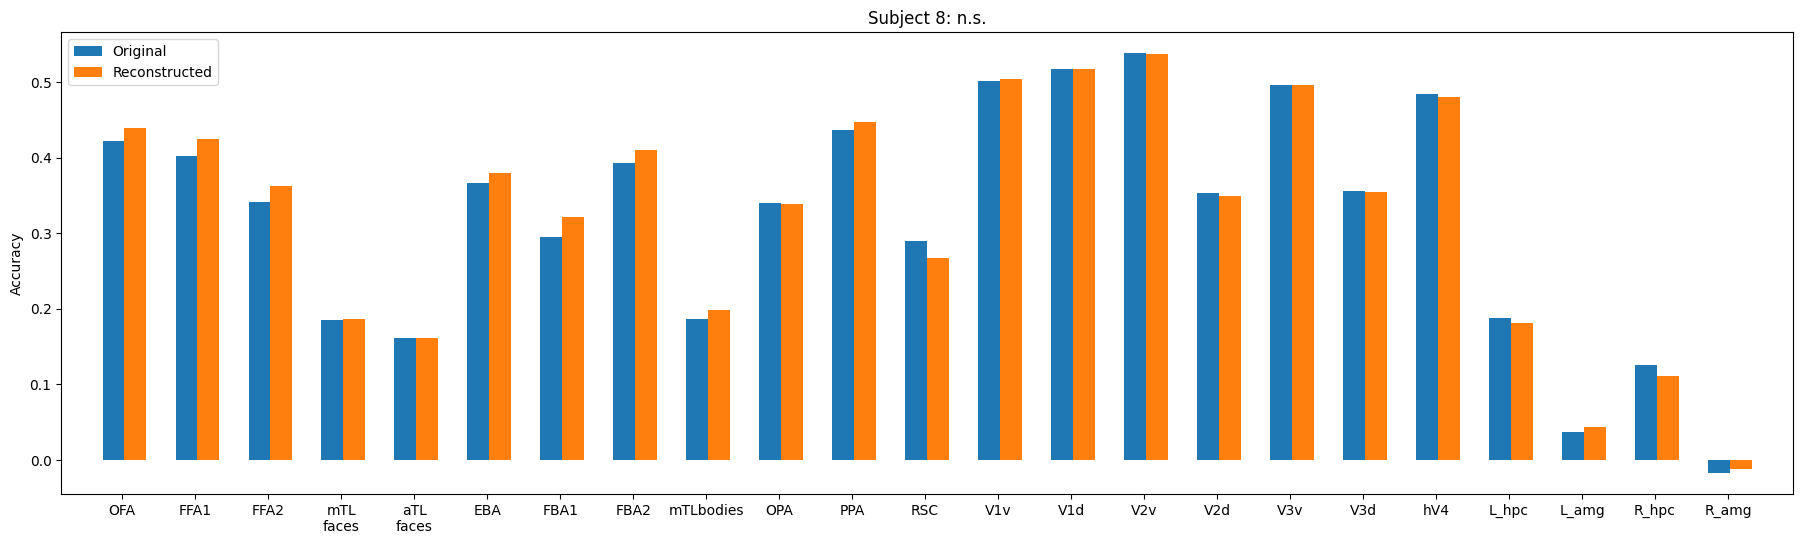

In [198]:
acc_dict = {
    "Original": accuracy,
    "Reconstructed": accuracy_regen
}

acc_z = np.arctanh(accuracy)
acc_regen_z = np.arctanh(accuracy_regen)

_, p_value = stats.ttest_rel(acc_z, acc_regen_z)
if p_value < 0.001:
    p_str = '***'
elif p_value < 0.01:
    p_str = '**'
elif p_value < 0.05:
    p_str = '*'
else:
    p_str = 'n.s.'

x = np.arange(len(accuracy))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0.6

fig, ax = plt.subplots(figsize=(16,6))

for attribute, measurement in acc_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Accuracy')
ax.set_xticks(ticks=x + width, labels=ROIs_label)
ax.legend(loc='upper left', ncols=1)
ax.set_title(f"Subject {subject}: {p_str}")

plt.gca().margins(x=0.025)
plt.gcf().canvas.draw()
tl = plt.gca().get_xticklabels()
maxsize = max([t.get_window_extent().width for t in tl])
m = 0.2 # inch margin
s = maxsize/plt.gcf().dpi*len(accuracy)+2*m
margin = m/plt.gcf().get_size_inches()[0]
plt.gcf().subplots_adjust(left=margin, right=1.-margin)
plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

# plt.show()
plt.savefig(subj_dir+'accuracy_compare.png', bbox_inches='tight')

In [199]:
# Paired t-test
t_test_dict["subject"].append(subject)
t_test_dict["ttest_p"].append(p_value)

# Wilcoxon rank test
_, p_wilcoxon = stats.wilcoxon(accuracy, accuracy_regen)
t_test_dict["wilcoxon_p"].append(p_wilcoxon)

# Pearson corr (again)
pearson_coef, p_pearsonr = stats.pearsonr(accuracy, accuracy_regen)
t_test_dict["pearson_p"].append(p_pearsonr)
t_test_dict["pearson_coef"].append(pearson_coef)

### Memorability-controlled images

In [200]:
# for i, imfile in enumerate(high_imgs):
#     high_img = PIL.Image.open(ctrld_dir+"increased/"+imfile).convert("RGB").resize((227, 227))
#     high_img = np.array(high_img, dtype=np.float32) / 255.
#     image_data[ctrld_nids[i]] = high_img.transpose((2, 0, 1))

for i, imfile in enumerate(high_imgs):
    nid = int(imfile.split("_")[0].split("shared")[-1])-1
    if nid in ctrld_nids:
        high_img = PIL.Image.open(ctrld_dir+"increased/"+imfile).convert("RGB").resize((227, 227))
        high_img = np.array(high_img, dtype=np.float32) / 255.
        image_data[nid] = high_img.transpose((2, 0, 1))

image_data.shape

(1000, 3, 227, 227)

In [201]:
# predict brain response
voxel_pred = get_predictions(image_data, fmaps, fwrf, model_params['params'])
high_voxel_pred = voxel_pred[ordering[:data_size][shared_mask]]
pred_act = np.zeros((1000,23))
pred_act[:,ROIs_bool[:,0]] = voxel_pred
print(pred_act.shape)
with open(subj_dir + 'voxel_pred_high.npy', 'wb') as f:
    np.save(f, pred_act)

samples [  900:999  ] of 1000, voxels [     0:22    ] of 23
---------------------------------------
total time = 4.513695s
sample throughput = 0.004514s/sample
voxel throughput = 0.196248s/voxel
(1000, 23)


In [202]:
# for i, imfile in enumerate(low_imgs):
#     low_img = PIL.Image.open(ctrld_dir+"decreased/"+imfile).convert("RGB").resize((227, 227))
#     low_img = np.array(low_img, dtype=np.float32) / 255.
#     image_data[ctrld_nids[i]] = low_img.transpose((2, 0, 1))

for i, imfile in enumerate(low_imgs):
    nid = int(imfile.split("_")[0].split("shared")[-1])-1
    if nid in ctrld_nids:
        low_img = PIL.Image.open(ctrld_dir+"decreased/"+imfile).convert("RGB").resize((227, 227))
        low_img = np.array(low_img, dtype=np.float32) / 255.
        image_data[nid] = low_img.transpose((2, 0, 1))

image_data.shape

(1000, 3, 227, 227)

In [203]:
# predict brain response
voxel_pred = get_predictions(image_data, fmaps, fwrf, model_params['params'])
low_voxel_pred = voxel_pred[ordering[:data_size][shared_mask]]
pred_act = np.zeros((1000,23))
pred_act[:,ROIs_bool[:,0]] = voxel_pred
print(pred_act.shape)
with open(subj_dir + 'voxel_pred_low.npy', 'wb') as f:
    np.save(f, pred_act)

samples [  900:999  ] of 1000, voxels [     0:22    ] of 23
---------------------------------------
total time = 6.742841s
sample throughput = 0.006743s/sample
voxel throughput = 0.293167s/voxel
(1000, 23)


In [204]:
print(test_voxel_pred.shape)
print(regen_voxel_pred.shape)
print(high_voxel_pred.shape)
print(low_voxel_pred.shape)

(298, 23)
(298, 23)
(298, 23)
(298, 23)


In [205]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

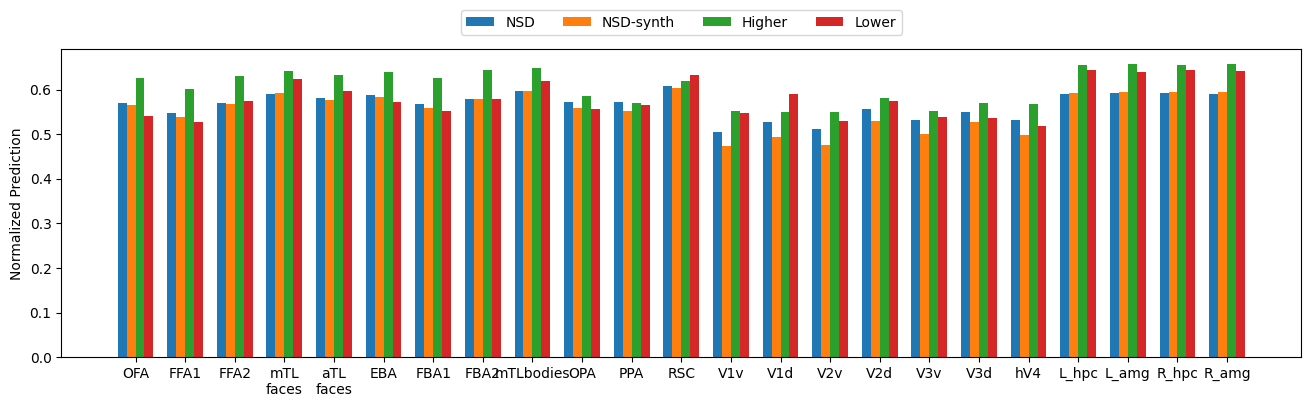

In [206]:
# pred_means = {
#     'Original': test_voxel_pred.mean(axis=0),
#     'Re-generate': regen_voxel_pred.mean(axis=0),
#     'Higher': high_voxel_pred.mean(axis=0),
#     'Lower': low_voxel_pred.mean(axis=0),
# }

pred_means = {
    'NSD': normalize(test_voxel_pred).mean(axis=0),
    'NSD-synth': normalize(regen_voxel_pred).mean(axis=0),
    'Higher': normalize(high_voxel_pred).mean(axis=0),
    'Lower': normalize(low_voxel_pred).mean(axis=0),
}

x = np.arange(len(accuracy))  # the label locations
width = 0.18  # the width of the bars
multiplier = -0.5

fig, ax = plt.subplots(figsize=(16,4))

for attribute, measurement in pred_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Prediction')
ax.set_ylabel('Normalized Prediction')
# ax.set_title('Penguin attributes by species')
ax.set_xticks(ticks=x + width, labels=ROIs_label)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fancybox=True)
# ax.set_ylim(0, 250)

plt.show()

In [207]:
t_stat_hl, p_value_hl = stats.ttest_rel(high_voxel_pred, low_voxel_pred, alternative="greater")

t_stat_oh, p_value_oh = stats.ttest_rel(test_voxel_pred, high_voxel_pred, alternative="less")
t_stat_ol, p_value_ol = stats.ttest_rel(test_voxel_pred, low_voxel_pred, alternative="greater")

t_stat_rh, p_value_rh = stats.ttest_rel(regen_voxel_pred, high_voxel_pred, alternative="less")
t_stat_rl, p_value_rl = stats.ttest_rel(regen_voxel_pred, low_voxel_pred, alternative="greater")


actual_ROIs = np.delete(ROIs, del_idx)
for i, roi in enumerate(actual_ROIs):
    t_test_dict[f"{roi}_high_low_p"].append(p_value_hl[i])
    t_test_dict[f"{roi}_orig_high_p"].append(p_value_oh[i])
    t_test_dict[f"{roi}_orig_low_p"].append(p_value_ol[i])
    t_test_dict[f"{roi}_recon_high_p"].append(p_value_rh[i])
    t_test_dict[f"{roi}_recon_low_p"].append(p_value_rl[i])

del_ROIs = list(set(default_ROIs) - set(actual_ROIs))
for droi in del_ROIs:
    t_test_dict[f"{droi}_high_low_p"].append(np.nan)
    t_test_dict[f"{droi}_orig_high_p"].append(np.nan)
    t_test_dict[f"{droi}_orig_low_p"].append(np.nan)
    t_test_dict[f"{droi}_recon_high_p"].append(np.nan)
    t_test_dict[f"{droi}_recon_low_p"].append(np.nan)

### Check t-test results

In [208]:
df_ttest = pd.DataFrame(t_test_dict)
df_ttest.to_csv(ctrld_dir+f"including_memory/resnet_{len(ctrld_nids)}/per_subj_ttest_rel.csv", index=False)
# df_ttest.to_csv(ctrld_dir+"per_subj_ttest_rel.csv", index=False)

In [209]:
mask_hl = [i for i, c in enumerate(df_ttest.columns) if ("high_low" in c) and (c.split('_')[0] not in ['OWFA', 'VWFA1', 'VWFA2', 'mfswords', 'mTLwords'])]
mask_oh = [i for i, c in enumerate(df_ttest.columns) if ("orig_high" in c) and (c.split('_')[0] not in ['OWFA', 'VWFA1', 'VWFA2', 'mfswords', 'mTLwords'])]
mask_ol = [i for i, c in enumerate(df_ttest.columns) if ("orig_low" in c) and (c.split('_')[0] not in ['OWFA', 'VWFA1', 'VWFA2', 'mfswords', 'mTLwords'])]
mask_rh = [i for i, c in enumerate(df_ttest.columns) if ("recon_high" in c) and (c.split('_')[0] not in ['OWFA', 'VWFA1', 'VWFA2', 'mfswords', 'mTLwords'])]
mask_rl = [i for i, c in enumerate(df_ttest.columns) if ("recon_low" in c) and (c.split('_')[0] not in ['OWFA', 'VWFA1', 'VWFA2', 'mfswords', 'mTLwords'])]

In [210]:
def print_non_nan_columns(row):
    non_nan_columns = [c.split('_')[0] for c in row[row.notna()].index.tolist() if c != "subject"]
    print(f"Subject {int(row.subject)} ({len(non_nan_columns)}/19): {non_nan_columns}")

In [211]:
df_sig = df_ttest[df_ttest["ttest_p"] > 0.05]

In [212]:
df_hl = pd.concat([df_sig[["subject"]], df_sig[df_ttest.iloc[:, mask_hl] < 0.05]], axis=1).dropna(axis=1, how='all')
df_high = pd.concat([df_sig[["subject"]], df_sig[df_ttest.iloc[:, mask_rh] < 0.05]], axis=1).dropna(axis=1, how='all')
df_low = pd.concat([df_sig[["subject"]], df_sig[df_ttest.iloc[:, mask_rl] < 0.05]], axis=1).dropna(axis=1, how='all')

In [213]:
print("NSD: Memorability-Increased - Memorability-Decreased")
df_hl.apply(print_non_nan_columns, axis=1)
print()

print("NSD: Synthesized - Memorability-Increased")
df_high.apply(print_non_nan_columns, axis=1)
print()

print("NSD: Synthesized - Memorability-Decreased")
df_low.apply(print_non_nan_columns, axis=1)
print()

NSD: Memorability-Increased - Memorability-Decreased
Subject 2 (12/19): ['OFA', 'FFA1', 'FFA2', 'aTLfaces', 'EBA', 'FBA2', 'V2v', 'V3v', 'hV4', 'L-hippocampus', 'L-amygdala', 'R-amygdala']
Subject 3 (10/19): ['OFA', 'FFA1', 'FFA2', 'aTLfaces', 'EBA', 'FBA1', 'FBA2', 'hV4', 'L-amygdala', 'R-amygdala']
Subject 5 (13/19): ['OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces', 'EBA', 'FBA1', 'FBA2', 'mTLbodies', 'hV4', 'L-hippocampus', 'L-amygdala', 'R-amygdala']
Subject 6 (11/19): ['OFA', 'FFA1', 'FFA2', 'aTLfaces', 'EBA', 'FBA1', 'FBA2', 'mTLbodies', 'hV4', 'L-amygdala', 'R-amygdala']
Subject 7 (9/19): ['OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces', 'EBA', 'FBA2', 'L-amygdala', 'R-amygdala']
Subject 8 (12/19): ['OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces', 'EBA', 'FBA1', 'FBA2', 'mTLbodies', 'hV4', 'L-amygdala', 'R-amygdala']

NSD: Synthesized - Memorability-Increased
Subject 2 (11/19): ['FFA2', 'aTLfaces', 'FBA2', 'V1v', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'L-amygdala', 'R-amygdala']
Subject 3

In [214]:
df_high = pd.concat([df_sig[["subject"]], df_sig[df_ttest.iloc[:, mask_oh] < 0.05]], axis=1).dropna(axis=1, how='all')
df_low = pd.concat([df_sig[["subject"]], df_sig[df_ttest.iloc[:, mask_ol] < 0.05]], axis=1).dropna(axis=1, how='all')

In [215]:
print("NSD: Original - Memorability-Increased")
df_high.apply(print_non_nan_columns, axis=1)
print()

print("NSD: Original - Memorability-Decreased")
df_low.apply(print_non_nan_columns, axis=1)
print()

NSD: Original - Memorability-Increased
Subject 2 (8/19): ['FFA2', 'aTLfaces', 'FBA2', 'V1v', 'V2v', 'V2d', 'L-amygdala', 'R-amygdala']
Subject 3 (9/19): ['OFA', 'FFA1', 'FFA2', 'aTLfaces', 'FBA1', 'V1v', 'V2v', 'L-amygdala', 'R-amygdala']
Subject 5 (4/19): ['FFA1', 'FBA2', 'mTLbodies', 'L-amygdala']
Subject 6 (3/19): ['FBA1', 'mTLbodies', 'L-amygdala']
Subject 7 (9/19): ['FFA1', 'FFA2', 'mTLfaces', 'aTLfaces', 'FBA2', 'V1v', 'V2v', 'V3v', 'hV4']
Subject 8 (0/19): []

NSD: Original - Memorability-Decreased
Subject 2 (12/19): ['OFA', 'FFA1', 'FFA2', 'aTLfaces', 'EBA', 'OPA', 'PPA', 'RSC', 'V3v', 'hV4', 'L-hippocampus', 'R-hippocampus']
Subject 3 (11/19): ['OFA', 'FFA2', 'EBA', 'FBA2', 'PPA', 'RSC', 'V3v', 'V3d', 'hV4', 'L-hippocampus', 'R-hippocampus']
Subject 5 (20/19): ['OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces', 'EBA', 'FBA1', 'FBA2', 'mTLbodies', 'OPA', 'PPA', 'RSC', 'V2d', 'V3v', 'V3d', 'hV4', 'L-hippocampus', 'L-amygdala', 'R-hippocampus', 'R-amygdala']
Subject 6 (19/19): ['OFA'

## For all NSD images

In [81]:
# parameters
subject = 8
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
model_name = 'dnn_fwrf'

# number of trials for all subjects
trials = np.array([30000, 30000, 24000, 22500, 30000, 24000, 30000, 22500])

# subj_dir = ctrld_dir+f"subj{subject:02d}/"
# subj_dir = ctrld_dir+f"including_memory/subj{subject:02d}/"
# os.makedirs(subj_dir, exist_ok=True)

save_dir = weight_root+f"S{subject:02d}/"

In [82]:
# load behavior data

exp_design = loadmat(exp_design_file)
# order of image id in trials
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)
print('ordering shape', ordering.shape)
# image id for each subject
subject_idx  = exp_design['subjectim']
print('subject_idx shape', subject_idx.shape)
# shared image id
shared_idx = exp_design['sharedix']

ordering shape (30000,)
subject_idx shape (8, 10000)


In [83]:
image_data = np.load("data/nsd/shared1000_227.npy")
image_data = image_data.astype(np.float32) / 255.

print('image data shape', image_data.shape)

image data shape (1000, 3, 227, 227)


In [84]:
# plt.imshow(image_data[0].transpose(1, 2, 0))

In [85]:
# choose the 1000 shared images

data_size = trials[subject-1]
ordering_data = ordering[:data_size]
print(ordering_data.shape)

(22500,)


In [86]:
shared_mask = ordering_data<1000  # the first 1000 indices are the shared indices
# shared_mask = np.in1d(ordering_data, ctrld_nids)
test_size = np.sum(shared_mask)
print('test size', test_size)

test size 2188


In [87]:
# load beta
ROIs = [
    'OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces',
    'EBA', 'FBA1', 'FBA2', 'mTLbodies',
    'OPA', 'PPA', 'RSC',
    # 'OWFA', 'VWFA1', 'VWFA2', 'mfswords', 'mTLwords', 
    'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4',
    'L-hippocampus', 'L-amygdala', 'R-hippocampus', 'R-amygdala'
]

roi_num = len(ROIs)
roi_data = np.zeros([data_size, roi_num])
n = 0
del_idx = []
for roi in ROIs:
    roi_data[:,n] = np.genfromtxt(meanROIbeta_root + f'subj{subject:02d}/meanbeta_' + roi + '.txt')
    if np.isnan(np.sum(roi_data[:,n])):
        print(roi)
        del_idx.append(n)
    n += 1

roi_data = np.delete(roi_data, del_idx, axis=1)
test_roi_data = roi_data[shared_mask]

print('test beta shape', test_roi_data.shape)

test beta shape (2188, 23)


In [88]:
# load encoding models
fwrf, fmaps = load_encoding(subject, model_name='dnn_fwrf')

# load params
model_params_set = h5py.File(weight_root+f'S{subject:02d}/model_params.h5py' , 'r')
# model_params_set = h5py.File(weight_root+f'S{subject:02d}/dnn_fwrf/model_params.h5py' , 'r')
model_params = embed_dict({k: np.copy(d) for k,d in model_params_set.items()})
model_params_set.close()

In [89]:
# predict brain response
voxel_pred = get_predictions(image_data, fmaps, fwrf, model_params['params'])
test_voxel_pred = voxel_pred[ordering[:data_size][shared_mask]]
print('test pred shape', test_voxel_pred.shape)

samples [  900:999  ] of 1000, voxels [     0:22    ] of 23
---------------------------------------
total time = 1.719454s
sample throughput = 0.001719s/sample
voxel throughput = 0.074759s/voxel
test pred shape (2188, 23)


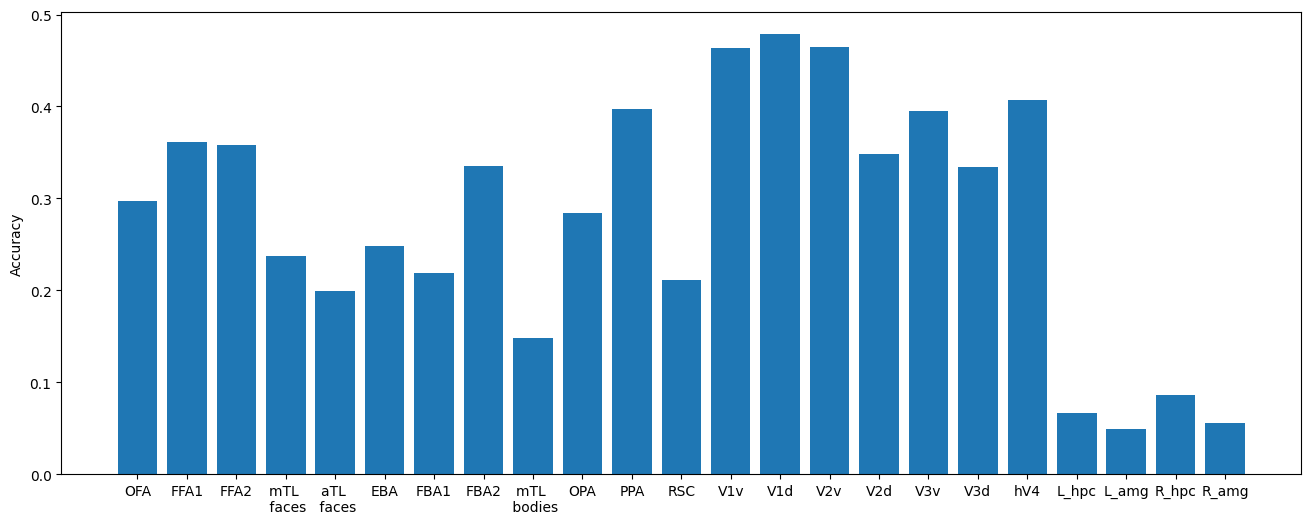

In [90]:
# correlate predicted response and beta
accuracy = np.zeros(shape=(test_voxel_pred.shape[1]))

for v in range(test_voxel_pred.shape[1]):
    accuracy[v] = np.corrcoef(test_roi_data[:,v], test_voxel_pred[:,v])[0,1]  
    

accuracy = np.nan_to_num(accuracy)

# plot the accuracy for all rois
# ROIs_label = ['OFA', 'FFA1', 'FFA2', 'mTL \n faces', 'aTL \n faces', 'EBA', 'FBA1', 'FBA2', 'mTL \n bodies', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA1', 'VWFA2', 'mfs \n words', 'mTL \n words', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
ROIs_label = ['OFA', 'FFA1', 'FFA2', 'mTL \n faces', 'aTL \n faces', 'EBA', 'FBA1', 'FBA2', 'mTL \n bodies', 'OPA', 'PPA', 'RSC', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'L_hpc', 'L_amg', 'R_hpc', 'R_amg']
ROIs_label = np.delete(ROIs_label,del_idx) 

plt.figure(figsize=(16,6))
plt.bar(ROIs_label,accuracy)
plt.ylabel('Accuracy')

# np.save(save_dir+"voxel_pred_nsd.npy", voxel_pred)
# np.save(save_dir+"accuracy.npy", accuracy)
plt.savefig(save_dir+'accuracy.png')

In [91]:
ROIs_bool = np.ones((23,1), dtype='bool')
ROIs_bool[del_idx] = False

pred_act = np.zeros((1000,23))
pred_act[:,ROIs_bool[:,0]] = voxel_pred

with open(save_dir + 'act_pred.npy', 'wb') as f:
    np.save(f, pred_act)

save_acc = np.zeros([1,23])
save_acc[:,ROIs_bool[:,0]] = accuracy

with open(save_dir + 'acc.npy', 'wb') as f:
    np.save(f, save_acc)